##### Copyright 2020 The TensorFlow Quantum Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Layerwise learning for quantum neural networks

Author : Andrea Skolik

Contributors : Masoud Mohseni

Created : 2019

Last updated : 2020-Jun-29

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/tensorflow/quantum/blob/research/layerwise_learning/layerwise_learning.ipynb)

In this notebook, we will use the technique introduced in [1] to efficiently train a quantum neural network without making any initial guesses about the structure that's neccessary to solve a certain learning task. To do this, we successively add layers to a QNN during training, which does not only make training faster, but also ensures a better signal-to-noise ratio compared to training the full circuit when done on real hardware.

It is well known that randomly initialized parametrized quantum circuits suffer from exponentially decaying gradients as circuits grow in size [2]. 
One strategy to avoid this is finding clever initialization schemes for deep circuits. Another approach which we take here instead focuses on the structure of the circuit, and shows how a deep parametrized circuit can be constructed during training. By training individual partitions of the circuit as it grows, we avoid the randomization effect that causes barren plateaus. This is mainly of importance on noisy intermediate-scale quantum (NISQ) devices, as these will suffer most from the unfavorable signal-to-noise ratio when running variational algorithms. As the gradients produced by circuits grow smaller, we need more and more measurements from a quantum device to accurately estimate them. When using layerwise learning (LL), gradients stay larger during training and we therefore need less measurements to get sufficient training signal for the optimizer. Additionally, we decrease the overall number of parameter updates, so that LL provides an efficient strategy to run variational algorithms on NISQ devices.

LL works in two phases as shown in the figure below:


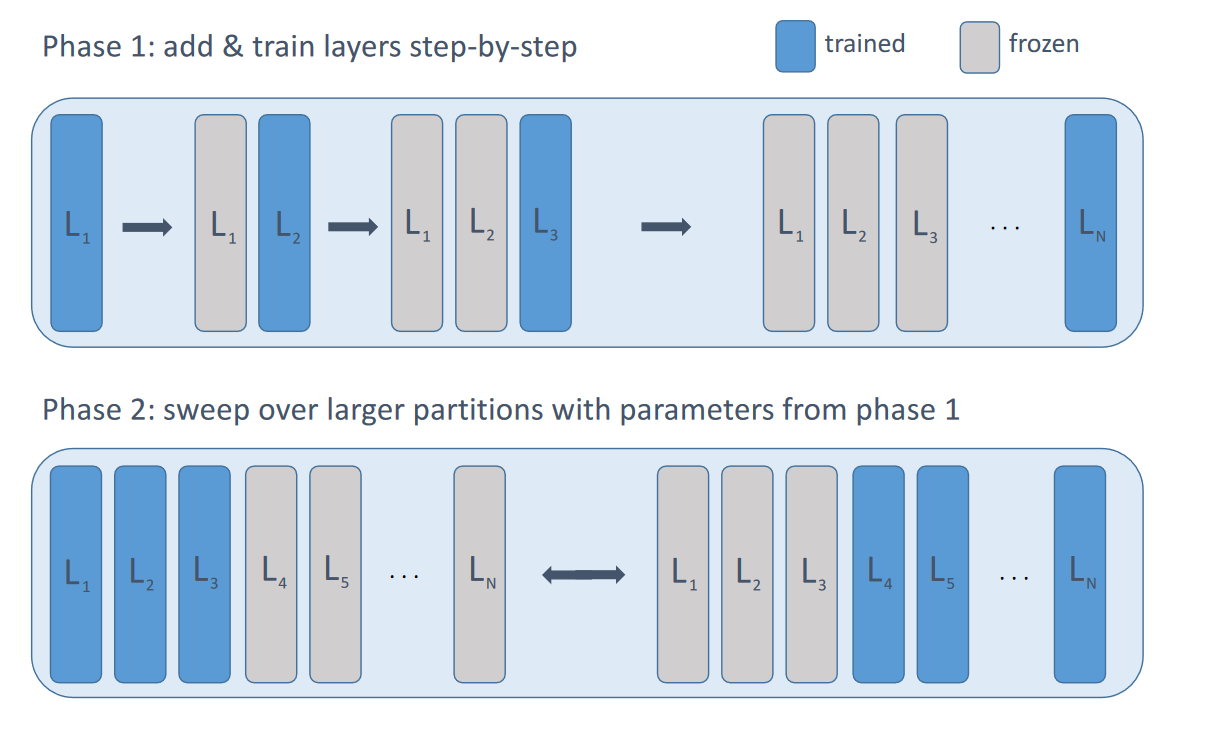

In [ ]:
# Do not rerun, or image will be deleted
from IPython.display import Image 
Image(filename='layers.png', embed=True, width=700)

<!--![Two phases of layerwise learning](images/layers.png)-->

In the first phase, we start training with a small number of layers and train those for a fixed number of epochs. After that, we add another set of layers and freeze the parameters of the previous step's layers. We repeat this process until the desired depth is reached. In phase two, we perform additional optimization sweeps over larger subsets of the layers using the final circuit configuration from phase one. The parameters from this circuit give us a good starting point to optimize quarters, halves, or even the full circuit without initializing on a barren plateau.

This kind of learning scheme can be used for various types of learning tasks and input data, so long as the QNN structure allows iteratively building the circuits. In this notebook we look at a simple example of classifying MNIST digits with randomly generated layers.



[1] Layerwise learning for quantum neural networks,  A. Skolik, J. R. McClean, M. Mohseni, P. van der Smagt, and M. Leib, 
https://arxiv.org/pdf/2006.14904.pdf

[2] Barren plateaus in quantum neural network training landscapes,   J.  R.  McClean,  S.  Boixo,  V.  N.  Smelyanskiy,  R.  Babbush,  and H. Neven, Nature Communications 9 (2018)

In [ ]:
!pip install --upgrade cirq==0.7.0

In [ ]:
!pip install --upgrade tensorflow==2.1.0

In [ ]:
!pip install tensorflow-quantum

In [ ]:
import collections
import itertools
import random
import copy

import cirq
import sympy
import numpy as np
import tensorflow_quantum as tfq
import tensorflow as tf
import matplotlib.pyplot as plt

First, we need to create the layers we want to use in our circuit. We construct layers that apply a randomly chosen X, Y, or Z gate on each qubit, and a ladder of CZ gates that connect them. This is the same structure as used in [2].

In [ ]:
def create_layer(qubits, layer_id):
    symbols = [sympy.Symbol(layer_id + '-' + str(i)) for i in range(len(qubits))]
    gate_set = [cirq.rx, cirq.ry, cirq.rz]

    gates = []
    symbol_gates = []
    for i, q in enumerate(qubits):
        chosen_gate = random.choice(gate_set)
        gates.append(chosen_gate(0)(q))
        symbol_gates.append(chosen_gate(symbols[i])(q))

    for control, target in zip(qubits, qubits[1:]):
        gates.append(cirq.CZ(control, target))
        symbol_gates.append(cirq.CZ(control, target))

    return gates, symbol_gates, symbols

We also need to prepare the training data. For simplicity, we borrow the training data and data input scheme from the MNIST classification example in the TFQ docs. Namely we downsample and flatten the images, such that we have vectors with binary entries. These bitstrings are then fed to the circuit by applying a layer of X gates to qubits that correspond to ones in the image vector.

In [ ]:
def reduce_image(x):
    x = tf.reshape(x, [1, 28, 28, 1])
    x = tf.image.resize(x, [4, 4])
    x = tf.reshape(x, [4, 4])
    x = x / 255
    return x.numpy()

def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    for x, y in zip(xs, ys):
        mapping[str(x)].add(y)

    return zip(*((x, y) for x, y in zip(xs, ys) if len(mapping[str(x)]) == 1))

def convert_to_circuit(image):
    values = np.ndarray.flatten(image)
    qubits = cirq.GridQubit.rect(1, len(values))
    circuit = cirq.Circuit()

    for i, value in enumerate(values):
        if value > 0.5:
            circuit.append(cirq.X(qubits[i]))

    return circuit

def convert_label(y):
    if y == 3:
        return 1.0
    else:
        return -1.0


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_train))

x_train, y_train = zip(*((x, y) for x, y in zip(x_train, y_train) if y in [3, 6]))
x_test, y_test = zip(*((x, y) for x, y in zip(x_test, y_test) if y in [3, 6]))

x_train = [reduce_image(x) for x in x_train]
x_test = [reduce_image(x) for x in x_test]

x_train, y_train = remove_contradicting(x_train, y_train)
x_test, y_test = remove_contradicting(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

x_train = [convert_to_circuit(x) for x in x_train]
x_test = [convert_to_circuit(x) for x in x_test]

y_train = [convert_label(y) for y in y_train]
y_test = [convert_label(y) for y in y_test]

11493376/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 60000
Number of filtered training examples: 11520
Number of filtered test examples: 1906


In [ ]:
# increase for more accurate results
NUM_EXAMPLES = 128
x_train = x_train[:NUM_EXAMPLES]
y_train = y_train[:NUM_EXAMPLES]

x_train = tfq.convert_to_tensor(x_train)
x_test = tfq.convert_to_tensor(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

### Phase I

Now we will set up our training loop. We specify the number of qubits in the circuit, how many layer addition steps to perform, and how many layers to add in each step. The latter is a hyperparameter of our model that can be tuned for the learning task at hand. There is a trade-off between keeping the trained partitions as small as possible, but at the same time not too small to make significant progress on the learning task. You can play with the hyperparameters below to notice this difference. We are not going to freeze the previous layers in phase one in this implementation, but simply grow the circuit incrementally. 

In [ ]:
n_qubits = 6
n_layer_steps = 5
n_layers_to_add = 2
data_qubits = cirq.GridQubit.rect(1, n_qubits)
readout = cirq.GridQubit(0, n_qubits-1)

symbols = []
layers = []
symbol_layers = []
weights = []

training_history = []

for layer_id in range(n_layer_steps):
    print("\nLayer:", layer_id)
    circuit = cirq.Circuit()
    for i in range(n_layers_to_add):
        layer, symbol_layer, layer_symbols = create_layer(data_qubits, f'layer_{layer_id}_{i}')
        layers.append(layer)
        symbol_layers.append(symbol_layer)
        symbols.append(layer_symbols)

    circuit += symbol_layers

    # prepare the readout qubit
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    circuit.append(cirq.X(readout))
    readout_op = cirq.Z(readout)

    # setup the Keras model
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    model.add(
        tfq.layers.PQC(
            model_circuit=circuit,
            operators=readout_op,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    print(model.summary())

    model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    # set parameters to 0 for new layers
    model.set_weights([np.pad(weights, (0, n_qubits*n_layers_to_add))])

    model.fit(x_train,
              y_train,
              batch_size=128,
              epochs=20,
              verbose=2,
              validation_data=(x_test, y_test))

    qnn_results = model.evaluate(x_test, y_test)
    training_history.append(qnn_results)

    weights = model.get_weights()[0]


Layer: 0
Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_27 (PQC)                 (None, 1)                 12        
Total params: 12
Trainable params: 12
Non-trainable params: 0
_________________________________________________________________
None
Train on 128 samples, validate on 1906 samples
Epoch 1/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 2/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 3/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 4/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 5/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 6/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 7/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 8/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 9/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 10/20
128/128 - 2s - loss: 1.0000 - val_loss: 1.0000
Epoch 11

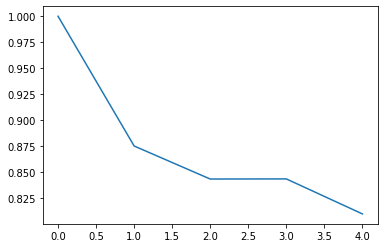

In [ ]:
plt.plot(training_history)

### Phase II

After our circuit has grown to the specified size, we now use this as a starting point to train larger partitions. This means that we will split the circuit by specifiying a percentage of layers that should be trained as one contiguous set. In the example below, we will split the circuit in half, and then alternatingy train the two halfs for *n_sweeps* times.

To do this with TFQ, we need to keep track of the symbols associated with each gate, and only include the symbols of gates in the circuit configuration which we actually want to train.

In [ ]:
partition_percentage = 0.5
partition_size = int(n_layer_steps*n_layers_to_add*partition_percentage)
n_partition_weights = partition_size*n_qubits
n_sweeps = 2

def train_partition(circuit, trained_weights):
    circuit.append(cirq.X(readout))
    circuit.append(cirq.H(readout))
    circuit.append(cirq.X(readout))

    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape=(), dtype=tf.dtypes.string))
    model.add(
        tfq.layers.PQC(
            model_circuit=circuit,
            operators=readout_op,
            differentiator=tfq.differentiators.ParameterShift(),
            initializer=tf.keras.initializers.Zeros))

    model.compile(loss=tf.keras.losses.squared_hinge,
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.01))

    print(model.summary())

    model.set_weights([trained_weights])
    model.fit(x_train,
              y_train,
              batch_size=128,
              epochs=20,
              verbose=1,
              validation_data=(x_test, y_test))

    part_weights = model.get_weights()[0]

    qnn_results = model.evaluate(x_test, y_test)
    training_history.append(qnn_results)

    return part_weights

print("\nSweep over partitions\n")
for sweep in range(n_sweeps):
    # configure and train first partition
    print("\nSweep {}, partition 1\n".format(sweep+1))

    trained_weights = weights[:n_partition_weights]
    untrained_weights = list(copy.copy(weights[n_partition_weights:][::-1]))
    untrained_layers = layers[partition_size:]

    # We can't alter a gate's parameter directly after it was initialized,
    # so we simply initialize a new gate with the new parameter by using
    # a slightly ugly hack to determine the gate type.
    for l in untrained_layers:
        for i, g in enumerate(l):
            if str(g)[:2] == 'Rx':
                l[i] = cirq.rx(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Ry':
                l[i] = cirq.ry(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Rz':
                l[i] = cirq.rz(untrained_weights.pop())(g.qubits[0])

    trained_circuit = cirq.Circuit()
    trained_circuit += symbol_layers[:partition_size]
    trained_circuit += untrained_layers
    part_weights = train_partition(trained_circuit, trained_weights)
    weights[:n_partition_weights] = part_weights

    # configure and train second partition
    print("\nSweep {}, partition 2\n".format(sweep+1))

    trained_weights = weights[n_partition_weights:]
    untrained_weights = list(copy.copy(weights[:n_partition_weights][::-1]))
    untrained_layers = layers[:partition_size]
    for l in untrained_layers:
        for i, g in enumerate(l):
            if str(g)[:2] == 'Rx':
                l[i] = cirq.rx(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Ry':
                l[i] = cirq.ry(untrained_weights.pop())(g.qubits[0])
            elif str(g)[:2] == 'Rz':
                l[i] = cirq.rz(untrained_weights.pop())(g.qubits[0])

    trained_circuit = cirq.Circuit()
    trained_circuit += untrained_layers
    trained_circuit += symbol_layers[partition_size:]

    part_weights = train_partition(trained_circuit, trained_weights)
    weights[n_partition_weights:] = part_weights



Sweep over partitions


Sweep 1, partition 1

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
pqc_40 (PQC)                 (None, 1)                 30        
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________
None
Train on 128 samples, validate on 1906 samples
Epoch 1/20
128/128 [==============================] - 11s 86ms/sample - loss: 0.7658 - val_loss: 0.7487
Epoch 2/20
128/128 [==============================] - 11s 83ms/sample - loss: 0.7639 - val_loss: 0.7498
Epoch 3/20
128/128 [==============================] - 10s 82ms/sample - loss: 0.7622 - val_loss: 0.7502
Epoch 4/20
128/128 [==============================] - 11s 82ms/sample - loss: 0.7607 - val_loss: 0.7498
Epoch 5/20
128/128 [==============================] - 10s 82ms/sample - loss: 0.7591 - val_loss: 0.7490
Epoch 6/20
128/128 [============

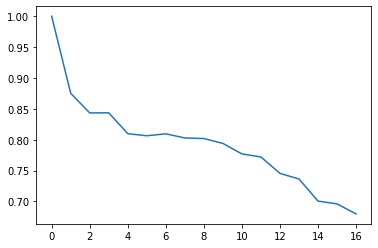

In [ ]:
plt.plot(training_history)

As already pointed out in the MNIST example notebook, a classical neural network is hard to beat on a simple learning task like this, especially with a basic data encoding scheme as used above. In general, layerwise learning can be used in arbitrary configurations that allow successively stacking and training layers, and it is independent of the data encoding scheme used - so feel free to play with more elaborate data sets as well!